In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf1
from tensorflow.keras import activations
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-26 18:00:06.772677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from cust_rnn import BasicRNNCell

In [145]:
n_windows = 200
n_input =  1
n_output = 1
size_train = 2001
r_neuron = 120   

In [146]:
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
ts = create_ts(start = '2001', n = 2205)

In [147]:
series = np.array(ts[3:])
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(2001,) (201,)


In [148]:
x_data = train[:size_train-1]
X_batches = x_data.reshape(-1, n_windows, n_input)
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [149]:
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)
print(X_batches.shape, y_batches.shape)

(10, 200, 1) (10, 200, 1)


In [151]:
X_test, y_test = create_batches(df = test, windows = 200,input = 1, output = 1)
print(X_test.shape, y_test.shape)

(10, 200, 1) (10, 200, 1)


In [157]:
params = {"l2scale":4e-6,
        "alpha_resample_ratio":0.9,
        "transition_std":[10,3,5],
        "time_step":1.0,
        "decayrate":0.5,
        "learningrate":0.0001,
        "num_particles":100,
        }

In [259]:
batch_num = 10
particle_states_inits = np.zeros((batch_num,params["num_particles"], 3)) 
for i in range(0,batch_num):
    ri = np.zeros((params["num_particles"], 3))
    tsi = x_data[i*n_windows:i*n_windows + 3]
    r = [tsi[2],  (tsi[2] - tsi[1]) / params['time_step'], ((tsi[2] - tsi[1]) - (tsi[1] - tsi[0])) / params['time_step']]
    for ridx in range(0,3):
        ri[:,ridx] = np.random.uniform(r[ridx] - params['transition_std'][ridx], r[ridx] + params['transition_std'][ridx], (params["num_particles"]))
    particle_states_inits[i] = ri


In [303]:
fv = np.log(1.0/float(params['num_particles']))
particle_weights_inits = np.full(shape=particle_states_inits.shape[:-1], fill_value=fv)

In [304]:
lag_len = 20
last_window_points = np.array([x_data[i-lag_len:i] if i>=lag_len else np.concatenate((np.zeros(lag_len-i),x_data[:i])) for i in range(0,len(x_data))]).reshape(batch_num, n_windows, -1)

In [305]:
from cust_rnn import PFNET

In [306]:
train_brain = PFNET(params, [particle_states_inits.shape, X_test.shape, (10,200,20)], y_test.shape, True)

In [307]:
m = tf.keras.Model(train_brain.inputs, train_brain.outputs)

In [308]:
fl = [X_batches, particle_states_inits, particle_weights_inits, last_window_points, y_batches]

In [310]:
[i.shape for i in fl]

[(10, 200, 1), (10, 100, 3), (10, 100), (10, 200, 20), (10, 200, 1)]

In [311]:
init_op = tf.group(tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer())
iteration = 1500 



with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    # obs_in, init_particle_states, init_particle_weights, prev_window, true_pos
    
    fd = {i:fl[idx] for idx, i in enumerate(train_brain.inputs)}
    # for iters in range(iteration):
    _, loss, _ = sess.run([train_brain.train_op, train_brain.train_loss_op,
                                               train_brain.update_state_op], feed_dict=fd)
    print(loss)

77683380000.0


In [ ]:
init = tf.compat.v1.global_variables_initializer() 
iteration = 1500 

with tf.compat.v1.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

In [10]:
X = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_input), batch_size=10)
y = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_output), batch_size=10)
# X = tf.placeholder(tf.float32, [None, n_windows, n_input])   
# y = tf.placeholder(tf.float32, [None, n_windows, n_output])

basic_cell = BasicRNNCell(r_neuron, activation=tf.nn.relu) 
# basic_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(r_neuron, activation=tf.nn.relu) 

# rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)              
rnn_output, states = tf.keras.layers.RNN(cell = basic_cell, dtype = tf.float32, return_sequences=True, return_state=True)(inputs = X)
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.keras.layers.Dense(n_output)(stacked_rnn_output)
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])

build called
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-11-26 18:00:10.570645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 18:00:10.574781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2022-11-26 18:00:10.595396: W tensorflow/c/c_api.cc:291] Operation '{name:'basic_rnn_cell/bias/Assign' id:21 op device:{requested: '', assigned: ''} def:{{{node basic_rnn_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](basic_rnn_cell/bias, basic_rnn_cell/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runn

In [15]:
rnn_output.shape

TensorShape([10, 20, 120])

In [16]:
outputs.shape

TensorShape([10, 20, 1])

In [11]:
# if type(rnn_output) == list:
#     print("list", len(rnn_output), [rnn_output[i].shape for i in range(len(rnn_output))])
# else:
#     print("tensor", rnn_output.shape)

In [12]:
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss) 

In [13]:
init = tf.compat.v1.global_variables_initializer() 
iteration = 1500 

with tf.compat.v1.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 432525.0
150 	MSE: 15412.571
300 	MSE: 4723.588
450 	MSE: 2603.9072
600 	MSE: 1838.4335
750 	MSE: 1382.105
900 	MSE: 997.9759
1050 	MSE: 981.67053
1200 	MSE: 685.2973
1350 	MSE: 595.8242


/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_20876/2606641324.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_20876/2606641324.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')


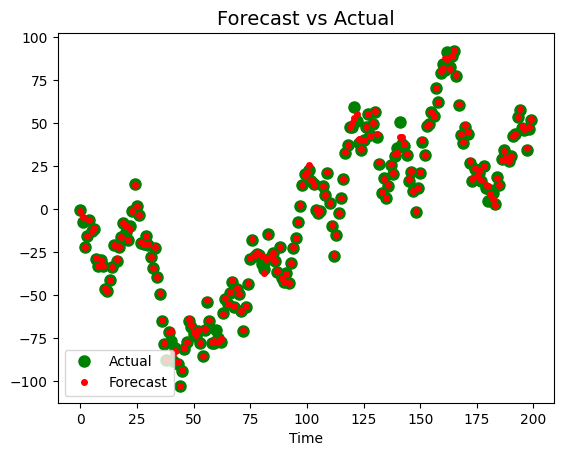

In [14]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()

In [169]:
from display_data import display_data

In [176]:
f = display_data("./data/train.tfrecords")

In [188]:
odometry = f['odometry'].bytes_list.value[0]
odometry = np.frombuffer(odometry, np.float32).reshape((-1, 3))